[Think Stats Chapter 8 Exercise 3](http://greenteapress.com/thinkstats2/html/thinkstats2009.html#toc77)

In games like hockey and soccer, the time between goals is roughly exponential. So you could estimate a team’s goal-scoring rate by observing the number of goals they score in a game. This estimation process is a little different from sampling the time between goals, so let’s see how it works.

Write a function that takes a goal-scoring rate, lam, in goals per game, and simulates a game by generating the time between goals until the total time exceeds one game, then returns the number of goals scored.
Write another function that simulates many games, stores the estimates of lam, then computes their mean error and RMSE.

Is this way of making an estimate biased? Plot the sampling distribution of the estimates and the 90% confidence interval. What is the standard error? What happens to sampling error for increasing values of `lam`?

This notebook has been converted to a markdown file using [convert_notebooks_to_markdown.py](./convert_notebooks_to_markdown.py).

# Answer

Mean error seems to decrease with the number of games sampled (this should be tested further with additional sample numbers), so this estimator does not appear to be biased.

he sampling distribution for 10000 games where the number of goals per game is 4 is below.

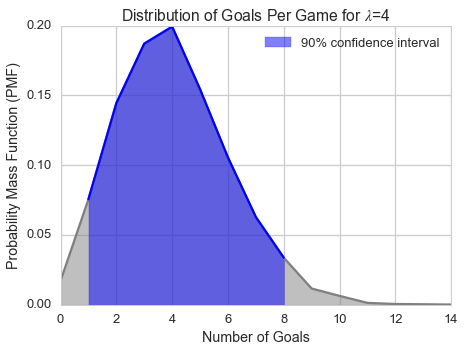

In [9]:
plt.show()

# Code

In [1]:
from __future__ import print_function
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from load_ThinkStats import load_FemPreg

%matplotlib inline
%config InlineBackend.close_figures = False

In [2]:
np.random.seed(42)

Functions to simulate time between goals and to run multiple games and determine the number of goals.

In [3]:
def sample_time_between_goals(lam):
    # Determine the number of goals per game
    # based on time between goals
    
    elapsed_time = 0.0
    goals = 0
    
    # Time is effectively normalized to fraction of game
    # to get actual time in minutes, the scale input
    # to the exponential sampler is multipled by game duration
    
    # NOTE: I believe the reciprocal of lambda is used
    # because it's the only way the values returned by
    # the sampler make sense
    
    while elapsed_time < 1.0:
        elapsed_time += np.random.exponential(scale=1./lam, size=1)[0]
        if elapsed_time > 1.0:
            break
        else:
            goals += 1
            
    return goals


def sample_many_games(lam, size):
    # Return an array of number of goals per game based on lambda    
    return np.array([sample_time_between_goals(lam) for _ in range(size)])

Statistical functions.

In [4]:
def calc_mean_error(lam, goal_array):
    # Mean Error
    return (goal_array - lam).mean()


def calc_rmse(lam, goal_array):
    # Root Mean Squared Error
    return np.sqrt(((goal_array - lam)**2).mean())


def calc_pmf(goal_array):
    # Probability Mass Function
    unique_vals = np.unique(goal_array)
    unique_vals.sort()
    
    prob_vals = np.array([(goal_array == x).sum() for x in unique_vals], dtype=np.float)
    prob_vals /= prob_vals.sum()
    
    return dict(val=unique_vals, prob=prob_vals)


def calc_cdf(goal_array):
    # Cumulative Distribution Function
    cdf_dict = calc_pmf(goal_array)
    
    cdf_dict['prob'] = cdf_dict['prob'].cumsum()
    
    return cdf_dict


def calc_percentile(goal_array, pct):
    # Calculate a percentile
    cdf_dict = calc_cdf(goal_array)
    
    pos = np.where(cdf_dict['prob'] >= pct)[0][0]
    return cdf_dict['val'][pos]

## Simulate games

In [5]:
# Average goals per game
lam = 4

# Number of games to simulate
size = 10000

# An array of goals per game
goal_array = sample_many_games(lam, size)

Calculate some statistics on the games.

In [6]:
mean_error = calc_mean_error(lam, goal_array)
rmse = calc_rmse(lam, goal_array)

pmf = calc_pmf(goal_array)
cdf = calc_cdf(goal_array)
ci = ( calc_percentile(goal_array, 0.05), calc_percentile(goal_array, 0.95) )

print('The mean error and RMSE are {:.3f} and {:.3f}, respectively.'.format(mean_error, rmse))

The mean error and RMSE are 0.030 and 2.012, respectively.


Test a smaller sample size to determine effect on RMSE.

In [7]:
goal_array2 = sample_many_games(lam, 100)
mean_error2 = calc_mean_error(lam, goal_array2)

print('The mean error for 100 games is {:.3f}.'.format(mean_error2))

The mean error for 100 games is -0.150.


## Visualize sampling results

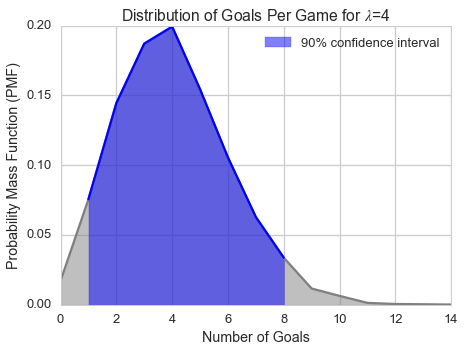

In [8]:
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure()
fig.set_size_inches(7, 5)

ax = plt.axes()

# Plot and shade the distribution
ax.plot(pmf['val'], pmf['prob'], color='gray')
ax.fill_between(pmf['val'], pmf['prob'], 
                 color='gray', alpha=0.5)

# Plot and shade the desired region
mask = (cdf['val'] >= ci[0]) & (cdf['val'] <= ci[1])
ax.plot(pmf['val'][mask], pmf['prob'][mask], 
         color='blue')
ax.fill_between(pmf['val'][mask], pmf['prob'][mask], 
                color='blue', alpha=0.5, 
                label='90% confidence interval')

ax.legend(loc=0)
ax.set_xlabel('Number of Goals')
ax.set_ylabel('Probability Mass Function (PMF)')
_ = ax.set_title('Distribution of Goals Per Game for $\lambda$={}'.format(lam))